In [1]:
import cv2
import matplotlib.pyplot as plt
import os
from roboflow import Roboflow

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
MATCH_START_TIME = 11*60 + 54
TRAIN_TIME = 3600 + 35*60 + 30

IMAGES_PATH = "/home/ubuntu/padel-analysis/data/datasets/object_detection/train"

In [3]:
os.environ.get("ROBOFLOW_API_KEY")

'm6ZX8hldswVW7md6PTkf'

In [4]:
video_path = "/home/ubuntu/padel-analysis/data/raw/wpt_1.mp4"

In [15]:
capture = cv2.VideoCapture(video_path)
fps = capture.get(cv2.CAP_PROP_FPS)


In [3]:
# Initialize the Roboflow object with your API key
rf = Roboflow(api_key=os.environ.get("ROBOFLOW_API_KEY"))

# Retrieve your current workspace and project name
print(rf.workspace())

# Specify the project for upload
# let's you have a project at https://app.roboflow.com/my-workspace/my-project
workspaceId = 'alroalroboflowsandbox'
projectId = 'padel-analysis'
project = rf.workspace(workspaceId).project(projectId)

loading Roboflow workspace...
{
  "name": "alroalroboflowsandbox",
  "url": "alroalroboflowsandbox",
  "projects": [
    "alroalroboflowsandbox/hard-hat-sample-eqpsn",
    "alroalroboflowsandbox/padel-analysis"
  ]
}
loading Roboflow workspace...


loading Roboflow project...


In [16]:


"""
Optional Parameters:
- num_retry_uploads: Number of retries for uploading the image in case of failure.
- batch_name: Upload the image to a specific batch.
- split: Upload the image to a specific split.
- tag: Store metadata as a tag on the image.
- sequence_number: [Optional] If you want to keep the order of your images in the dataset, pass sequence_number and sequence_size..
- sequence_size: [Optional] The total number of images in the sequence. Defaults to 100,000 if not set.
"""

sequence_size = len(range(MATCH_START_TIME, TRAIN_TIME, 5))
image_count = 0
BATCH_SIZE = 100
for i, frame_time_seconds in enumerate(range(MATCH_START_TIME, TRAIN_TIME, 5)):

    capture.set(cv2.CAP_PROP_POS_MSEC, frame_time_seconds*1000)
    frame_number = capture.get(cv2.CAP_PROP_POS_FRAMES)

    image_name = f"frame_{int(frame_number)}_seconds_{frame_time_seconds}.jpg"

    image_path = IMAGES_PATH + "/" + image_name
    
    res, frame = capture.read()
    if res:
        cv2.imwrite(image_path, frame)

        batch_number = 1 + image_count // BATCH_SIZE

        project.upload(
            image_path=image_path,
            batch_name=f"batch_{batch_number}",
            split="train",
            num_retry_uploads=3,
            sequence_number=i,
            sequence_size=sequence_size
        )

        image_count += 1

loading Roboflow workspace...


{
  "name": "alroalroboflowsandbox",
  "url": "alroalroboflowsandbox",
  "projects": [
    "alroalroboflowsandbox/hard-hat-sample-eqpsn",
    "alroalroboflowsandbox/padel-analysis"
  ]
}
loading Roboflow workspace...
loading Roboflow project...


In [4]:
dataset = project.version(2).download(model_format='yolov8', location="../padel-analysis/data/datasets/object_detection/players", overwrite=True)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Extracting Dataset Version Zip to ../padel-analysis/data/datasets/object_detection/players in yolov8:: 100%|██████████| 490/490 [00:00<00:00, 584.26it/s]


In [27]:
from ultralytics import YOLO

yolo = YOLO("yolov8x.pt")

100%|██████████| 131M/131M [00:02<00:00, 48.4MB/s] 


In [5]:
from datetime import datetime

eventid = datetime.now().strftime('%Y-%m-%d_%H-%M-%S-%f')
eventid

'2024-07-13_15-29-35-758098'

In [29]:
import torch

In [ ]:
class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        y1 = self.m(x)
        y2 = self.m(y1)
        return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))

In [35]:
cv1 = torch.nn.Conv2d(3, 16, 3, 1, 1)
cv2 = torch.nn.Conv2d(16, 32, 3, 1, 1)
m = torch.nn.MaxPool2d(kernel_size=5, stride=1, padding=5 // 2)

x = torch.randn(5,3,80,80)

In [36]:
x = cv1(x)
y1 = m(x)
y2 = m(y1)

In [39]:
x.shape, y1.shape, y2.shape

(torch.Size([5, 16, 80, 80]),
 torch.Size([5, 16, 80, 80]),
 torch.Size([5, 16, 80, 80]))

In [28]:
yolo

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(400, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_r

In [42]:
torch.full((80 * 80, 1), 0).shape

torch.Size([6400, 1])

In [43]:
        sx = torch.arange(end=w, device=device, dtype=dtype) + grid_cell_offset  # shift x
        sy = torch.arange(end=h, device=device, dtype=dtype) + grid_cell_offset  # shift y
        sy, sx = torch.meshgrid(sy, sx, indexing="ij") if TORCH_1_10 else torch.meshgrid(sy, sx)

tensor([0., 0., 0.])

In [40]:
globals()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  'import cv2\nimport matplotlib.pyplot as plt\nimport os\nfrom roboflow import Roboflow\n\nfrom dotenv import load_dotenv\nload_dotenv()',
  'MATCH_START_TIME = 11*60 + 54\nTRAIN_TIME = 3600 + 35*60 + 30\n\nIMAGES_PATH = "/home/ubuntu/padel-analysis/data/datasets/object_detection/train"',
  'os.environ.get("ROBOFLOW_API_KEY")',
  'video_path = "/home/ubuntu/padel-analysis/data/raw/wpt_1.mp4"',
  '# Initialize the Roboflow object with your API key\nrf = Roboflow(api_key=os.environ.get("ROBOFLOW_API_KEY"))\n\n# Retrieve your current workspace and project name\nprint(rf.workspace())\n\n# Specify the project for upload\n# let\'s you have a project at https://app.roboflow.com/my-workspace/my-project\nworkspaceId = \'a

In [25]:
for k, v in yolo.named_parameters():
    print(k, v.shape)

model.model.0.conv.weight torch.Size([16, 3, 3, 3])
model.model.0.bn.weight torch.Size([16])
model.model.0.bn.bias torch.Size([16])
model.model.1.conv.weight torch.Size([32, 16, 3, 3])
model.model.1.bn.weight torch.Size([32])
model.model.1.bn.bias torch.Size([32])
model.model.2.cv1.conv.weight torch.Size([32, 32, 1, 1])
model.model.2.cv1.bn.weight torch.Size([32])
model.model.2.cv1.bn.bias torch.Size([32])
model.model.2.cv2.conv.weight torch.Size([32, 48, 1, 1])
model.model.2.cv2.bn.weight torch.Size([32])
model.model.2.cv2.bn.bias torch.Size([32])
model.model.2.m.0.cv1.conv.weight torch.Size([16, 16, 3, 3])
model.model.2.m.0.cv1.bn.weight torch.Size([16])
model.model.2.m.0.cv1.bn.bias torch.Size([16])
model.model.2.m.0.cv2.conv.weight torch.Size([16, 16, 3, 3])
model.model.2.m.0.cv2.bn.weight torch.Size([16])
model.model.2.m.0.cv2.bn.bias torch.Size([16])
model.model.3.conv.weight torch.Size([64, 32, 3, 3])
model.model.3.bn.weight torch.Size([64])
model.model.3.bn.bias torch.Size([64]

In [38]:
len(range(MATCH_START_TIME, TRAIN_TIME, 5))

1004

In [11]:
for frame_time_seconds in range(MATCH_START_TIME, TRAIN_TIME, 5):

    capture.set(cv2.CAP_PROP_POS_MSEC, MATCH_START_TIME*1000)
    frame_number = capture.get(cv2.CAP_PROP_POS_FRAMES)
    
    # res, frame = capture.read()
    # plt.imshow(frame)
    a+=1
    pass

In [ ]:
capture.set(cv2.CAP_PROP_POS_MSEC, MATCH_START_TIME*1000)
res, frame = capture.read()
plt.imshow(frame)



In [12]:
a

1004

In [36]:
capture.set(cv2.CAP_PROP_POS_MSEC, 120040)
res, frame = capture.read()
capture.get(cv2.CAP_PROP_POS_MSEC)

120040.0

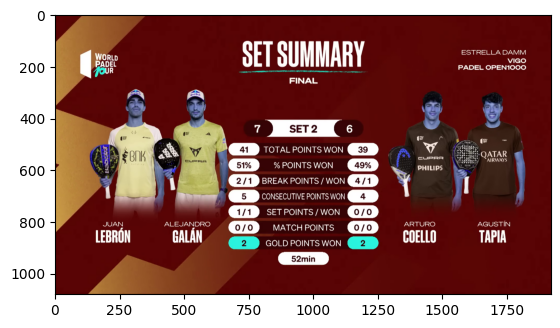

In [44]:
res

True

In [35]:
TRAIN_TIME*fps

142500.0

In [21]:
capture.get(cv2.CAP_PROP_FPS)

25.0

In [22]:
int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

258332

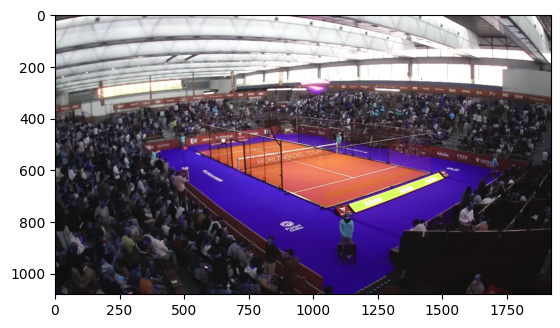

(1080, 1920, 3)